<a href="https://colab.research.google.com/github/maxwelfreitas/colab/blob/master/TrabalhoFinal_Ci%C3%AAncia_de_Dados_Enap.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Trabalho Final - Ciência de Dados - Enap / 2020

### Apresentação do Dataset

![LogoPainelCovidES](https://coronavirus.es.gov.br/Media/Coronavirus/_Profiles/3f5f4f05/cce1c02/Logo.PNG?v=637344489574979707)

**Microdados da pandemia de Coronavírus no Estado do Espírito Santo**

O governo do Estado do Espírito Santo disponibiliza os microdados do acompanhamento da pandemia de coronavírus no sítio do Painel COVID-19 do Espírito Santo.
Não há uma especificação formal do formato do arquivo de dados, contudo, sua extrutura é auto explicativa, cobrindo quase todas as informações necessárias para análise individualizada dos dados.  


#### Link para Download do Dataset

In [ ]:
# Cole o link do dataset aqui
# microdados painel covid ES
url = 'https://bi.static.es.gov.br/covid19/MICRODADOS.csv'


### Motivação

Acompanhar a evolução da pandemia de COVID-19 no Estado do Espírito Santo através de análise customizada, além daquelasjá publicadas no Painel COVID-ES 

### Investigação

In [ ]:
#Imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math
import datetime
import seaborn as sns
import matplotlib.cm as cm
from matplotlib.colors import Normalize

%matplotlib inline


In [ ]:
# microdados painel covid ES
url = 'https://bi.static.es.gov.br/covid19/MICRODADOS.csv'

# abrir o arquivo em um dataframe
df_covid_es = pd.read_csv(url,sep=';',encoding='latin1')

/opt/conda/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3071: DtypeWarning: Columns (4,6) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [ ]:
#localizar e substituir as datas inválidas no dataframe
ColunasData = ['DataNotificacao', 'DataCadastro', 'DataDiagnostico', 'DataColeta_RT_PCR', 'DataColetaTesteRapido', 'DataEncerramento', 'DataObito']

datas = df_covid_es[ColunasData].stack().unique()

datasInvalidas = []
datasValidas = []

for data in datas:
    try:
        dataValida = pd.to_datetime(data)
        datasValidas.append(dataValida)
    except:
        datasInvalidas.append(data)
        
# algumas datas apresentam erro de digitação
# para esta análise serão considerados como válidos mês e ano de cada data inválida ou anterior ou posterior a 2020

datasInvalidas = datasInvalidas +  [str(data)[:10] for data in datasValidas if data.year < 2020 or data.year > 2020]
DatasParaSubstituir = {data:data.replace(data[:4],'2020') for data in datasInvalidas}
df_covid_es[ColunasData] = df_covid_es[ColunasData].replace(DatasParaSubstituir)
df_covid_es[ColunasData] = df_covid_es[ColunasData].apply(lambda x: pd.to_datetime(x))

DatasParaSubstituir

{'0202-08-31': '2020-08-31',
 '0202-09-01': '2020-09-01',
 '0028-08-20': '2020-08-20',
 '0202-08-20': '2020-08-20',
 '0202-07-15': '2020-07-15',
 '0202-07-22': '2020-07-22',
 '0202-07-16': '2020-07-16',
 '0205-05-28': '2020-05-28',
 '0202-04-16': '2020-04-16',
 '0024-08-20': '2020-08-20',
 '0202-04-10': '2020-04-10',
 '2010-07-28': '2020-07-28',
 '2007-06-30': '2020-06-30',
 '2001-08-20': '2020-08-20',
 '2012-08-20': '2020-08-20',
 '2018-08-13': '2020-08-13',
 '2000-08-20': '2020-08-20',
 '2019-08-10': '2020-08-10',
 '2000-06-20': '2020-06-20'}

In [ ]:
# substituir campos categóricos por numéricos para facilitar cálculos

ColunasSintomasComorbidade = ['Febre', 'DificuldadeRespiratoria', 'Tosse', 'Coriza', 'DorGarganta', 'Diarreia',
                              'Cefaleia', 'ComorbidadePulmao', 'ComorbidadeCardio', 'ComorbidadeRenal', 
                              'ComorbidadeDiabetes', 'ComorbidadeTabagismo', 'ComorbidadeObesidade','FicouInternado', 
                              'ViagemBrasil','ViagemInternacional', 'ProfissionalSaude', 'PossuiDeficiencia','MoradorDeRua']

SintomasComorbidadeParaSubstituir = {'Não': 0, 'Sim':1,'Não Informado':np.nan, 'Ignorado':np.nan, '-':np.nan}

df_covid_es[ColunasSintomasComorbidade] = df_covid_es[ColunasSintomasComorbidade].replace(SintomasComorbidadeParaSubstituir)

**Evolução de Novos Casos Confirmados**

In [ ]:
df_confirmados = df_covid_es[df_covid_es['Classificacao']=='Confirmados'].reset_index(drop=True)

# será considerada a data da confirmação a data da coleta do exame ou a data do encerramento do caso
# no dataset há casos em que as três datas não estão presentes, nesse casos, esta análise será feita 
# considerando a data da confirmação a data do cadastramento

DataConfirmado = ['DataColeta_RT_PCR','DataColetaTesteRapido','DataEncerramento','DataCadastro']
df_confirmados['DataConfirmado'] = df_confirmados[DataConfirmado].apply(lambda x: min(x[:3]) if pd.notna(min(x[:3])) else x[3],axis=1)
df_confirmados['Confirmado'] = 1
df_confirmados['Óbito'] = df_confirmados['Evolucao'].apply(lambda x: 1 if x=='Óbito pelo COVID-19' else 0 )

# obtidos os dados diários, calcula-se a média móvel de 7 e 14 dias para melhor observação da tendência

df_confirmados = df_confirmados[['DataConfirmado','Confirmado']].groupby(by='DataConfirmado').agg('sum').reset_index()
df_confirmados['Acumulado'] = df_confirmados['Confirmado'].cumsum()
df_confirmados['MediaMovel7'] = df_confirmados['Confirmado'].rolling(7).mean()
df_confirmados['MediaMovel14'] = df_confirmados['Confirmado'].rolling(14).mean()

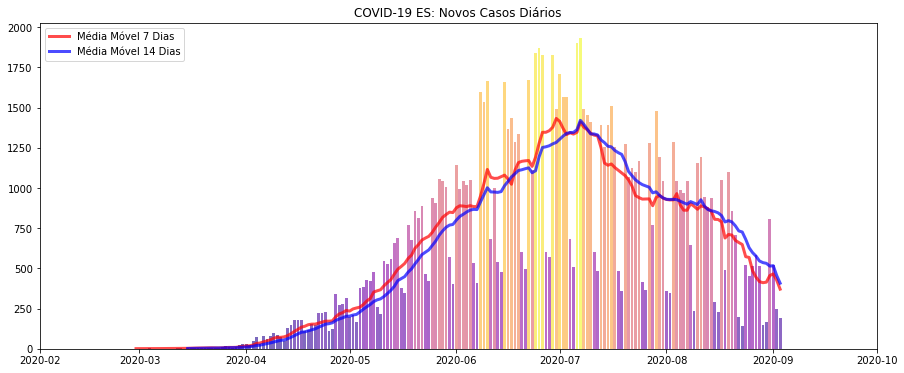

In [ ]:
fig, ax = plt.subplots(1,1,figsize=(15,6))

x_max = max(df_confirmados['DataConfirmado']).to_pydatetime()
x_max = datetime.date(x_max.year,x_max.month+1,1)
x_min = datetime.date(2020,2,1)
ax.set_xlim(x_min,x_max)

# plotar casos diários
my_cmap = cm.get_cmap('plasma')
my_norm = Normalize(vmin=0, vmax=max(df_confirmados['Confirmado']))
ax.bar(df_confirmados['DataConfirmado'],df_confirmados['Confirmado'],
       color=my_cmap(my_norm(df_confirmados['Confirmado'])),alpha=0.6)

ax.plot(df_confirmados['DataConfirmado'],df_confirmados['MediaMovel7'],
        linewidth=3,alpha=0.7,
        color='red',label='Média Móvel 7 Dias')

ax.plot(df_confirmados['DataConfirmado'],df_confirmados['MediaMovel14'],
        linewidth=3,alpha=0.7,
        color='blue',label='Média Móvel 14 Dias')

ax.set_title('COVID-19 ES: Novos Casos Diários')
ax.legend(loc='upper left');

**Evolução de Óbitos**

In [ ]:
df_obitos = df_covid_es[df_covid_es['Evolucao']=='Óbito pelo COVID-19'].reset_index(drop=True)

ColunasObitos = ['DataObito', 'Municipio', 'FaixaEtaria', 'IdadeNaDataNotificacao', 'Sexo', 'RacaCor', 
                 'Escolaridade', 'ComorbidadePulmao', 'ComorbidadeCardio', 'ComorbidadeRenal', 'ComorbidadeDiabetes', 
                 'ComorbidadeTabagismo', 'ComorbidadeObesidade', 'ProfissionalSaude']

ColunasComorbidades = ['ComorbidadePulmao', 'ComorbidadeCardio', 'ComorbidadeRenal', 'ComorbidadeDiabetes',
                       'ComorbidadeTabagismo', 'ComorbidadeObesidade']

df_obitos = df_obitos[ColunasObitos]
df_obitos['Comorbidades'] = df_obitos[ColunasComorbidades].apply(lambda x: sum(x),axis=1)
df_obitos['Obito'] = 1

# obtidos os dados diários, calcula-se a média móvel de 7 e 14 dias para melhor observação da tendência

df_obitos_diario = df_obitos[['DataObito','Obito']].groupby(['DataObito']).sum().reset_index()
df_obitos_diario['MediaMovel7'] = df_obitos_diario['Obito'].rolling(7).mean()  
df_obitos_diario['MediaMovel14'] = df_obitos_diario['Obito'].rolling(14).mean()

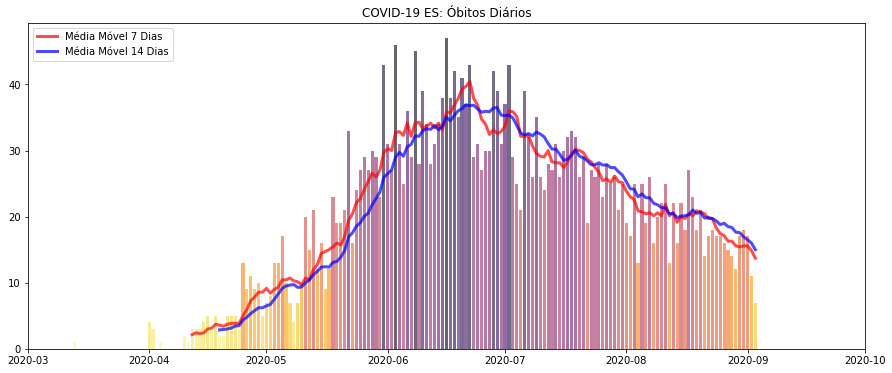

In [ ]:
fig, ax = plt.subplots(1,1,figsize=(15,6))

x_max = max(df_confirmados['DataConfirmado']).to_pydatetime()
x_max = datetime.date(x_max.year,x_max.month+1,1)
x_min = datetime.date(2020,3,1)
ax.set_xlim(x_min,x_max)

# plotar casos diários
my_cmap = cm.get_cmap('inferno')
my_norm = Normalize(vmin=0, vmax=max(df_obitos_diario['Obito']))
ax.bar(df_obitos_diario['DataObito'],df_obitos_diario['Obito'],
       color=my_cmap(1-my_norm(df_obitos_diario['Obito'])),alpha=0.6)

ax.plot(df_obitos_diario['DataObito'],df_obitos_diario['MediaMovel7'],
        linewidth=3,alpha=0.7,
        color='red',label='Média Móvel 7 Dias')

ax.plot(df_obitos_diario['DataObito'],df_obitos_diario['MediaMovel14'],
        linewidth=3,alpha=0.7,
        color='blue',label='Média Móvel 14 Dias')

ax.set_title('COVID-19 ES: Óbitos Diários')
ax.legend(loc='upper left');

**Óbitos por Sexo e Faixa Etária**

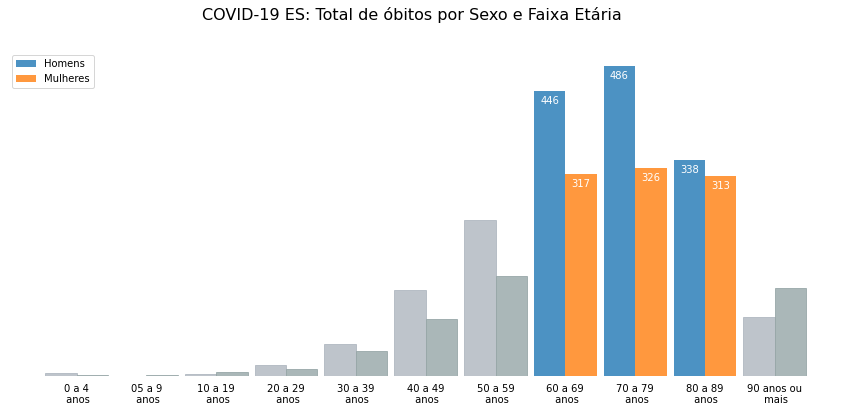

In [ ]:
# histograma de óbitos por faixa etária

hist_obitos = df_covid_es[df_covid_es['Classificacao']=='Confirmados'].reset_index(drop=True)
hist_obitos['Confirmado'] = 1
hist_obitos['Obito'] = hist_obitos['Evolucao'].apply(lambda x: 1 if x=='Óbito pelo COVID-19' else 0 )
hist_obitos = hist_obitos[['FaixaEtaria','Sexo','Confirmado','Obito']].groupby(['FaixaEtaria','Sexo']).sum().reset_index()
hist_obitos['taxa_obitos'] = (hist_obitos['Obito']/hist_obitos['Confirmado'])

#hist_obitos = df_obitos[['FaixaEtaria','Sexo','Obito']].groupby(['FaixaEtaria','Sexo']).sum().reset_index()
hist_obitos.set_index('FaixaEtaria',inplace=True)

homens = pd.pivot(hist_obitos,columns='Sexo').fillna(value=0)['Obito']['M']
mulheres = pd.pivot(hist_obitos,columns='Sexo').fillna(value=0)['Obito']['F']

x = np.arange(len(homens))  # the label locations
width = 0.45  # the width of the bars

fig, ax = plt.subplots(figsize=(15,6))
bar_homens = ax.bar(x - width/2, homens, width, label='Homens',alpha=0.8)
bar_mulheres = ax.bar(x + width/2, mulheres, width, label='Mulheres',alpha=0.8)

ax.set_xticks(range(len(homens.index)))
ax.set_xticklabels([label[:-5]+'\n'+label[-5:] for label in homens.index]);

fig.suptitle('COVID-19 ES: Total de óbitos por Sexo e Faixa Etária',fontsize=16)
ax.legend(loc='upper left');

bar_clarear = [0,1,2,3,4,5,6,10]
for bar in bar_clarear:
    bar_homens[bar].set_color('#AEB6BF')
    bar_mulheres[bar].set_color('#95A5A6')

for bar in [7,8,9]:
    ax.text(bar_mulheres[bar].get_x() + bar_mulheres[bar].get_width()/2, 
            bar_mulheres[bar].get_height()-20, 
            str(int(bar_mulheres[bar].get_height())),ha='center',color='w')
    
    ax.text(bar_homens[bar].get_x() + bar_homens[bar].get_width()/2, 
            bar_homens[bar].get_height()-20, 
            str(int(bar_homens[bar].get_height())),ha='center',color='w')

#ax.tick_params(top='off', bottom='off', left='off', right='off', labelleft='off', labelbottom='on')
ax.tick_params(bottom=False, top=False, left=False, right=False, labelleft=False)
for spine in ax.spines.values():
    spine.set_visible(False)
    

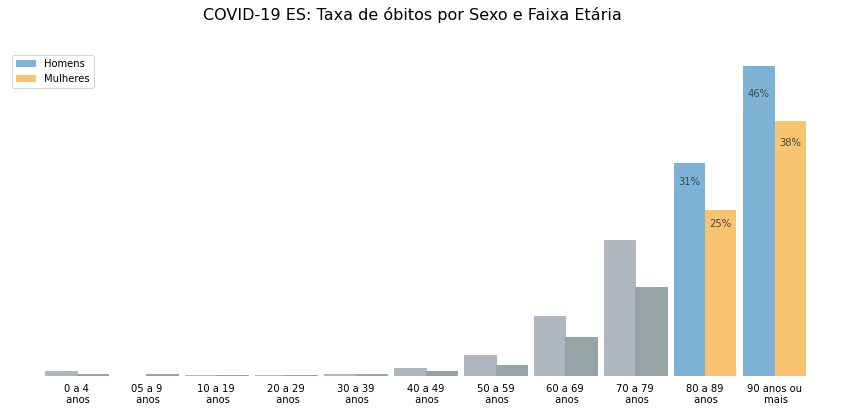

In [ ]:
taxa_homens = pd.pivot(hist_obitos,columns='Sexo').fillna(value=0)['taxa_obitos']['M']
taxa_mulheres = pd.pivot(hist_obitos,columns='Sexo').fillna(value=0)['taxa_obitos']['F']

x = np.arange(len(taxa_homens))  # the label locations
width = 0.45  # the width of the bars

fig, ax = plt.subplots(figsize=(15,6))
bar_homens = ax.bar(x - width/2, taxa_homens, width, label='Homens',color='#7FB3D5')
bar_mulheres = ax.bar(x + width/2, taxa_mulheres, width, label='Mulheres',color='#F8C471')

ax.set_xticks(range(len(taxa_homens.index)))
ax.set_xticklabels([label[:-5]+'\n'+label[-5:] for label in taxa_homens.index]);

fig.suptitle('COVID-19 ES: Taxa de óbitos por Sexo e Faixa Etária',fontsize=16)
ax.legend(loc='upper left');


for bar in range(9):
    bar_homens[bar].set_color('#AEB6BF')
    bar_mulheres[bar].set_color('#95A5A6')


for bar in [9,10]:
    ax.text(bar_mulheres[bar].get_x() + bar_mulheres[bar].get_width()/2, 
            bar_mulheres[bar].get_height()*0.9,
            "{:.0%}".format(bar_mulheres[bar].get_height()),ha='center', color='#424949')
    
    ax.text(bar_homens[bar].get_x() + bar_homens[bar].get_width()/2, 
            bar_homens[bar].get_height()*0.9,
            "{:.0%}".format(bar_homens[bar].get_height()),ha='center', color='#424949')

#ax.tick_params(top='off', bottom='off', left='off', right='off', labelleft='off', labelbottom='on')
ax.tick_params(bottom=False, top=False, left=False, right=False, labelleft=False)
for spine in ax.spines.values():
    spine.set_visible(False)

In [ ]:
print("{:.0%}".format(0.2))

20%


**Óbitos por Comorbidade**

In [ ]:
bar_clarear = [0,1,2,3,4,5,6,10]
for bar in bar_clarear:
    bar_homens[bar].set_color('#1F77B4')
    bar_mulheres[bar].set_color('#1F77B4')

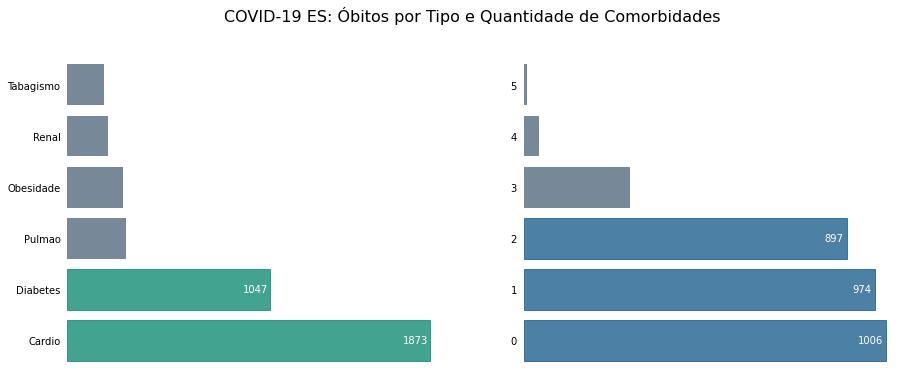

In [ ]:
ColunasComorbidades = ['ComorbidadePulmao','ComorbidadeCardio', 'ComorbidadeRenal', 'ComorbidadeDiabetes',
                       'ComorbidadeTabagismo', 'ComorbidadeObesidade', 'Comorbidades','Obito']

df_comorbidades = df_obitos[ColunasComorbidades].fillna(value=0)

obitos_tipo_comorbidade = df_comorbidades.sum()[:-2].sort_values(ascending=False)
obitos_quant_comorbidade = df_comorbidades.groupby(by='Comorbidades').sum()['Obito'][0:5]

fig, ax = plt.subplots(1,2,figsize=(15,6))

x_tipo_comorbidade = np.arange(len(obitos_tipo_comorbidade)) 
x_quant_comorbidade = np.arange(len(obitos_quant_comorbidade)) 

bar_tipo_comorbidade = ax[0].barh(x_tipo_comorbidade,obitos_tipo_comorbidade,color='lightslategrey')
ax[0].set_yticks(x_tipo_comorbidade)
ax[0].set_yticklabels([x.replace('Comorbidade','') for x in obitos_tipo_comorbidade.index]);

bar_quant_comorbidade = ax[1].barh(x_quant_comorbidade,obitos_quant_comorbidade,color='lightslategrey')
ax[1].set_yticks([int(i) for i in obitos_quant_comorbidade.index]);

fig.suptitle('COVID-19 ES: Óbitos por Tipo e Quantidade de Comorbidades',fontsize=16)

'''
for bar in [7,8,9]:
    ax.text(bar_mulheres[bar].get_x() + bar_mulheres[bar].get_width()/2, 
            bar_mulheres[bar].get_height()-20, 
            str(int(bar_mulheres[bar].get_height())),ha='center',color='w')
    
    ax.text(bar_homens[bar].get_x() + bar_homens[bar].get_width()/2, 
            bar_homens[bar].get_height()-20, 
            str(int(bar_homens[bar].get_height())),ha='center',color='w')
'''
#ax.tick_params(top='off', bottom='off', left='off', right='off', labelleft='off', labelbottom='on')
for axn in ax:
    axn.tick_params(bottom=False, top=False, left=False, right=False, labelleft=True,labelbottom=False)
    for spine in axn.spines.values():
        spine.set_visible(False)
for i,b in enumerate(bar_tipo_comorbidade[:2]):
    ax[0].text(b.get_width()-10,i,int(b.get_width()),va='center',ha='right',color='w')
    b.set_color('#138D75')
    b.set_alpha(0.8)

for i,b in enumerate(bar_quant_comorbidade[:3]):
    ax[1].text(b.get_width()-10,i,int(b.get_width()),va='center',ha='right',color='w')
    b.set_color('#1F618D')
    b.set_alpha(0.8)

### Conclusões e Achados

O pico da epidemia de COVID-19 no ES ocorreu entre a segunda quinzena de junho e a primeira quinzena de julho

A população com maior quantidade de óbitos, situa-se na faixa etária de 60 a 89 anos. O risco de morte aumenta conforme a idade, sendo superior a 25% a partir dos 80 anos. Homens são mais suscetíveis que as mulheres.

A comorbidade com maior fator de risco é cardio, seguida de diabetes. Em um terço dos óbitos não havia nenhuma comorbidade e mais da metade dos óbitos tinham uma ou duas comorbidades. 